In [1]:
import os
os.chdir(os.path.expanduser("~/phd/phd_nbeats_with_feature_vector"))

import neurokit2 as nk
import numpy as np
import sklearn as sk
from challenge import *
import matplotlib.pyplot as plt
import pandas as pd
from functools import reduce
import math
import ecg_plot



In [2]:
def clean_labels(header):
    logger.debug(f"Clean label for header file: {header}")
    classes_from_header = get_labels(header)
    
    logger.debug(f"Classes found in header: {classes_from_header}")
    if '733534002' in classes_from_header:
        classes_from_header[classes_from_header.index('733534002')] = '164909002'
        classes_from_header = list(set(classes_from_header))
    if '713427006' in classes_from_header:
        classes_from_header[classes_from_header.index('713427006')] = '59118001'
        classes_from_header = list(set(classes_from_header))
    if '63593006' in classes_from_header:
        classes_from_header[classes_from_header.index('63593006')] = '284470004'
        classes_from_header = list(set(classes_from_header))
    if '427172004' in classes_from_header:
        classes_from_header[classes_from_header.index('427172004')] = '17338001'
        classes_from_header = list(set(classes_from_header))

    return classes_from_header


In [3]:
# Constants
data_directory="../data/physionet.org/files/challenge-2021/1.0.3/training/georgia/g1"
leads = ('I', 'II', 'III', 'aVR', 'aVL', 'aVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6')

xls = pd.ExcelFile('label_mappings.xlsx')
df = pd.read_excel(xls, 'G12EC')

df_labels_to_class_list=df[['SNOMED code','Diagnosis in the dataset']].set_index('SNOMED code').apply(lambda row: {row.name: row.values.tolist()[0]}, axis=1).tolist()
labels_to_class= reduce(lambda a, b: a|b, df_labels_to_class_list)

Finished loading: 999 files
['426783006']
['sinus rhythm']


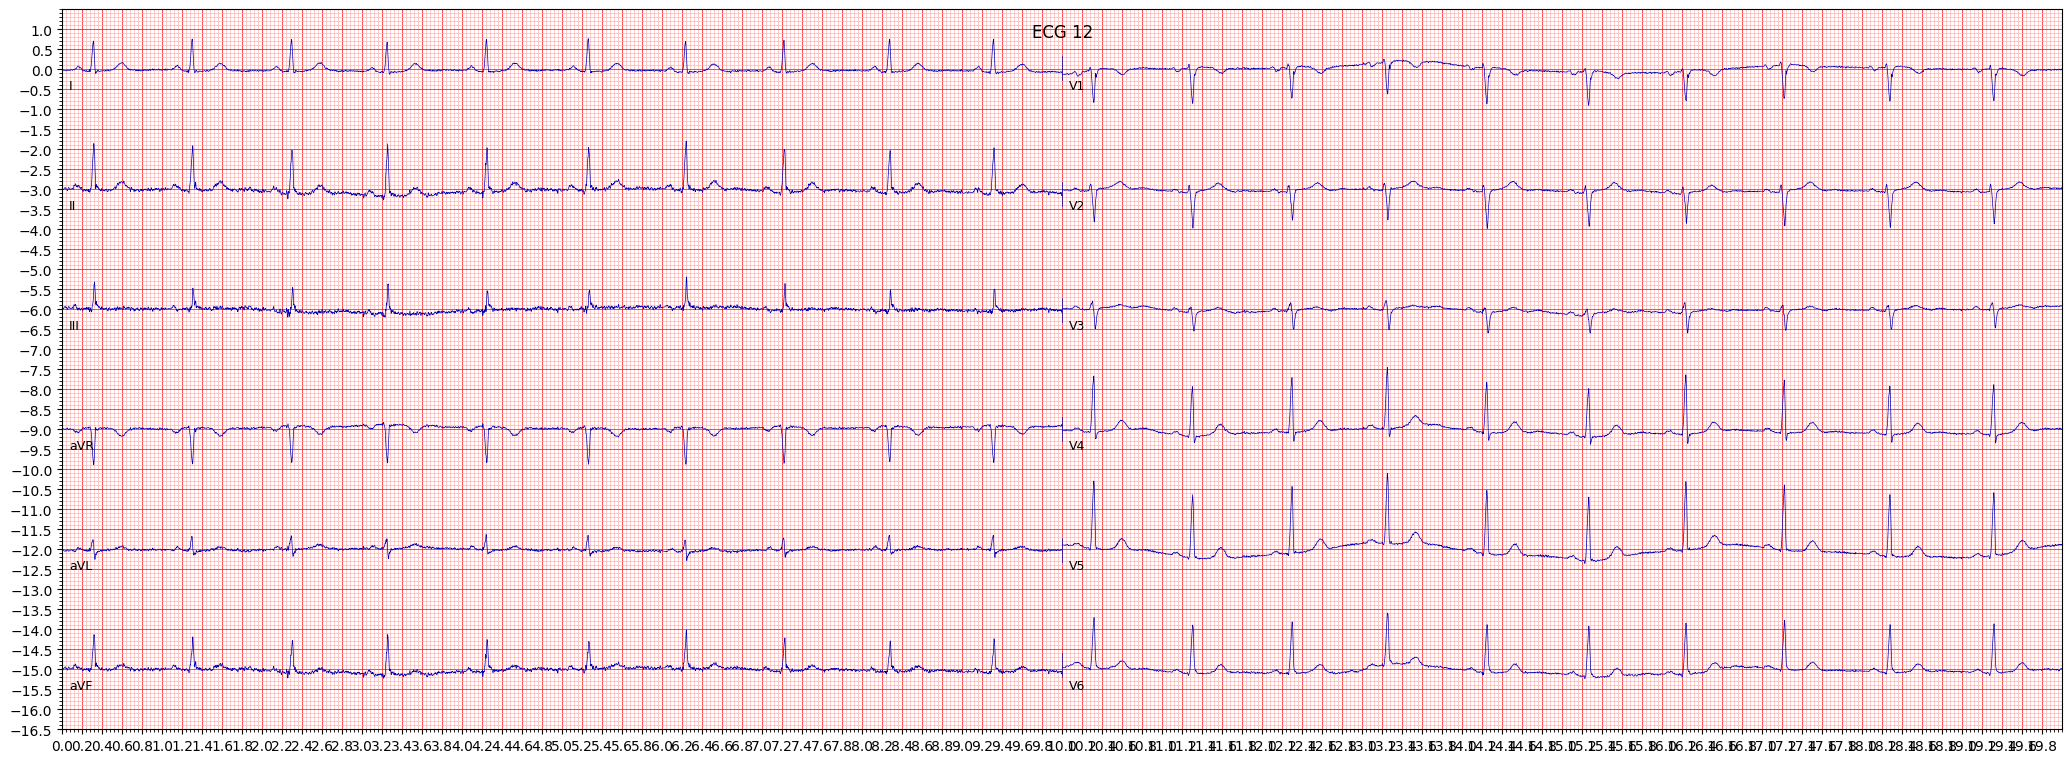

In [4]:

header_files, recording_files = find_challenge_files(data_directory)
num_recordings = len(header_files)
    
print(f"Finished loading: {num_recordings} files")
recording_index = 15

header = load_header(header_files[recording_index])
current_labels= clean_labels(header)
print(current_labels)
current_abbreviations=[labels_to_class[int(label)] for label in current_labels]
print(current_abbreviations)

recording_good = np.array(load_recording(recording_files[recording_index]), dtype=np.float32)
recording_full = get_leads_values(header, recording_good, leads)

ecg_plot.plot(recording_good / 1000, sample_rate = 500, title = 'ECG 12')
ecg_plot.show()


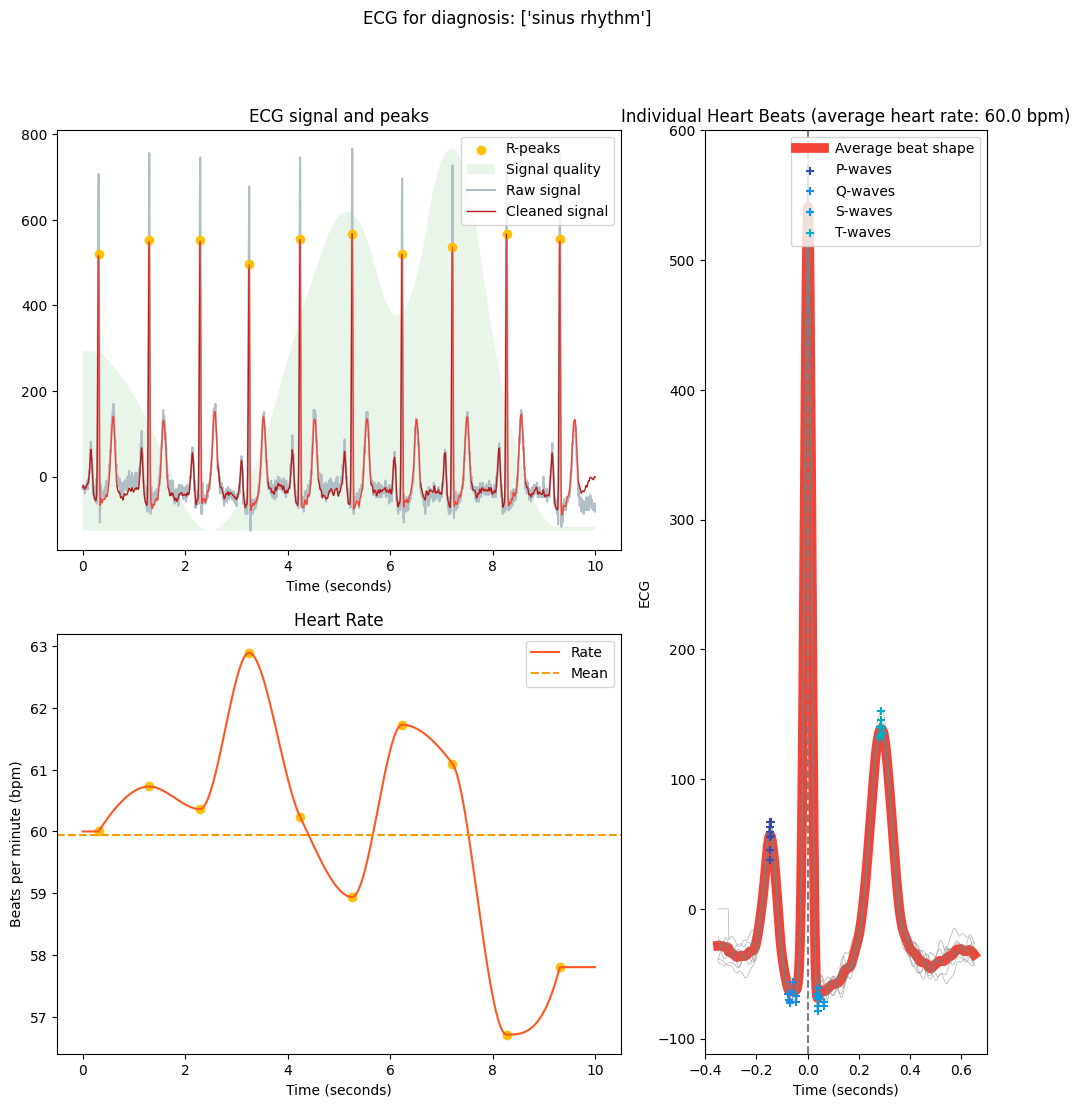

In [5]:
signals, info = nk.ecg_process(recording_good[0], sampling_rate=500)

# Visualise the processing
nk.ecg_plot(signals, info)
fig = plt.gcf() 
fig.set_size_inches(12, 12, forward=True)
fig.suptitle(f"ECG for diagnosis: {current_abbreviations}")

bpm=np.mean(nk.ecg_rate(signals, sampling_rate=500))


ECG_Raw                            -126.000000
ECG_Clean                           -12.280512
ECG_Rate                             59.895183
ECG_Quality                           1.000000
ECG_R_Peaks                           0.000000
ECG_P_Peaks                           0.000000
ECG_P_Onsets                          0.000000
ECG_P_Offsets                         0.000000
ECG_Q_Peaks                           0.000000
ECG_R_Onsets                          0.000000
ECG_R_Offsets                         0.000000
ECG_S_Peaks                           0.000000
ECG_T_Peaks                           0.000000
ECG_T_Onsets                          0.000000
ECG_T_Offsets                         0.000000
ECG_Phase_Atrial                           NaN
ECG_Phase_Completion_Atrial           0.000000
ECG_Phase_Ventricular                      NaN
ECG_Phase_Completion_Ventricular      0.000000
Name: 0, dtype: float64


Text(0.5, 0.98, "ECG Lead V1 for diagnosis: ['sinus rhythm']")

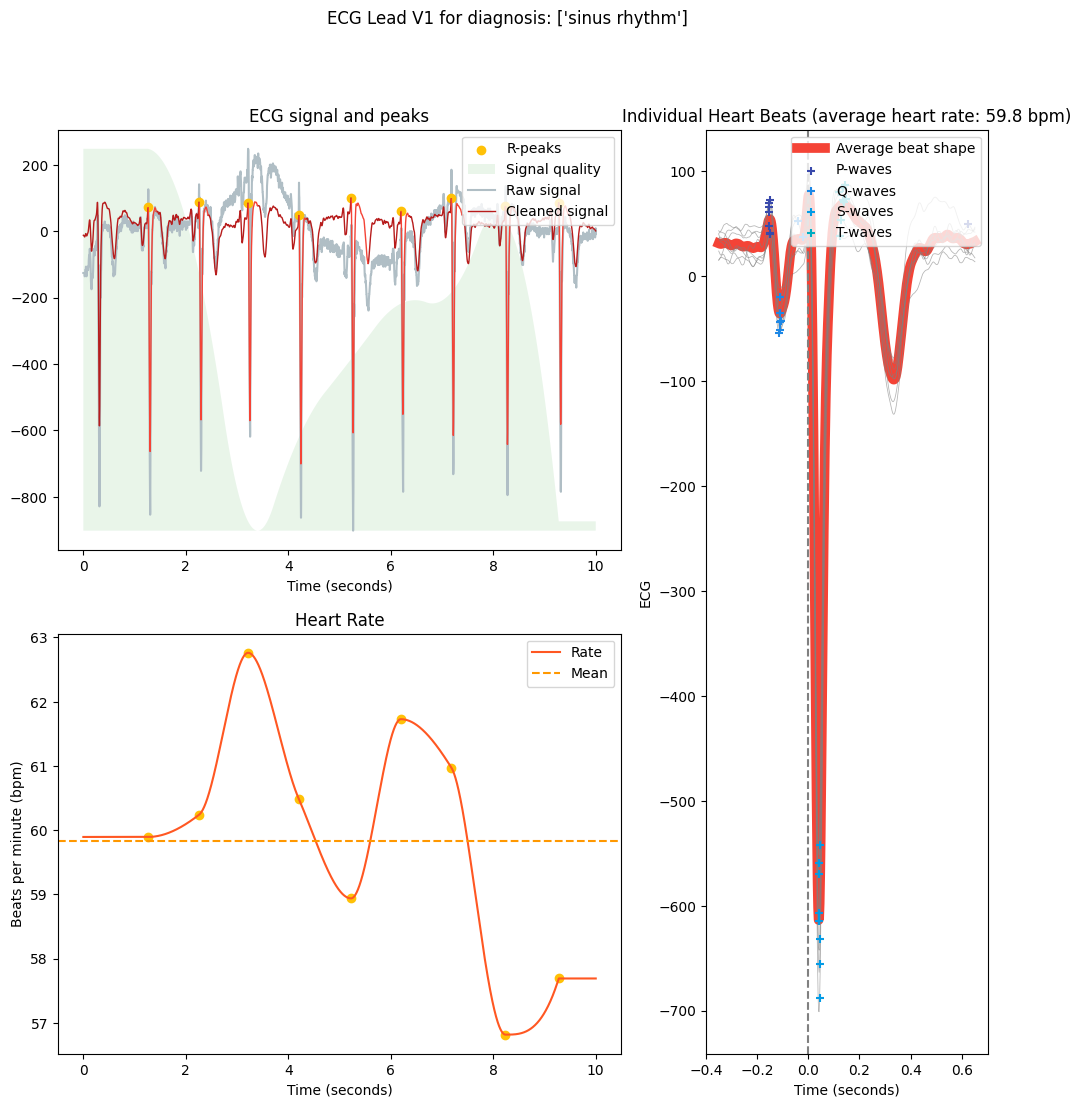

In [6]:
signals_V6, info_V6 = nk.ecg_process(recording_good[6], sampling_rate=500)
print(signals_V6.iloc[0])

# Visualise the processing

#This plot is good but R peaks are totally wrong (they should be at the lowest peak).
nk.ecg_plot(signals_V6, info_V6)
fig = plt.gcf() 
fig.set_size_inches(12, 12, forward=True)
fig.suptitle(f"ECG Lead V1 for diagnosis: {current_abbreviations}")


Is inverted: True


Text(0.5, 0.98, "ECG Lead V1 for diagnosis: ['sinus rhythm']")

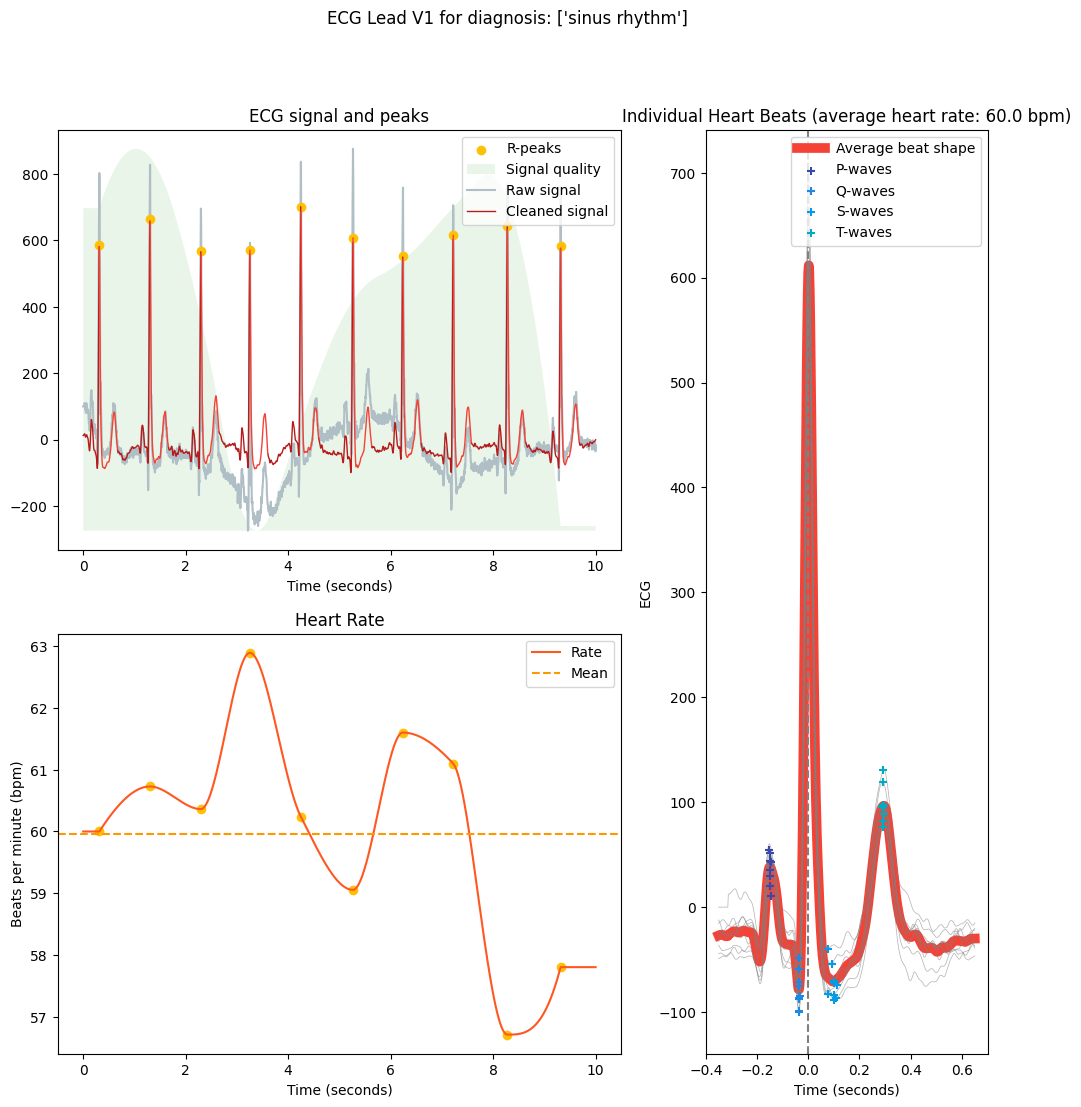

In [7]:
ecg, inverted = nk.ecg_invert(recording_good[6], sampling_rate=500)
print(f"Is inverted: {inverted}")
signals_V6, info_V6 = nk.ecg_process(ecg, sampling_rate=500)

# Visualise the processing

#This plot is good but R peaks are totally wrong (they should be at the lowest peak).
nk.ecg_plot(signals_V6, info_V6)
fig = plt.gcf() 
fig.set_size_inches(12, 12, forward=True)
fig.suptitle(f"ECG Lead V1 for diagnosis: {current_abbreviations}")


In [8]:
def leading_rythm(bpm):
    if(bpm < 50):
       return -1
    elif (50< bpm < 100):
        return 0
    else:
        return 1

leading_rythm(bpm)

0

In [9]:
def get_wavelet_orientation(onset, peak, offset):
    if peak > (onset+offset)/2 :
        return 1
    else:
        return -1

#R->L (correct) return 1, L->R (incorrect) return -1 LEAD I
def get_right_left_activation_leadI(p_complexes):
    return np.mean([get_wavelet_orientation(*px) for px in p_complexes])

#Correct sinus return 1 (pwave positive), Extra sinus orign return -1 (pwave negative) on lead II or lead III or aVF
def get_vertical_orientation(p_complexes):
    return np.mean([get_wavelet_orientation(*px) for px in p_complexes])

def get_p_complex(signals, info):
    num_peaks = len(info['ECG_P_Peaks'])
    result=[]
    for i in range(num_peaks):
        p_on = info['ECG_P_Onsets'][i]
        p = info['ECG_P_Peaks'][i]
        p_off = info['ECG_P_Offsets'][i]

        if np.isnan([p_on, p, p_off]).any():
            continue

        p_complex = [signals.iloc[p_on]['ECG_Raw'], signals.iloc[p]['ECG_Raw'], signals.iloc[p_off]['ECG_Raw']]
        
        if np.isnan(p_complex).any():
            continue
        else:
            result.append(p_complex)
    return result
    
#          | R   |  L
#---------------------
# top-down | 1 1 | 1 -1
#---------------------
# down-top | -1 1 | -1 -1
def get_rhythm_origin(signalsI, infoI, signalsII, infoII):
    I_pcomplexes = get_p_complex(signalsI, infoI)
    II_pcomplexes = get_p_complex(signalsII, infoII)

    return get_vertical_orientation(II_pcomplexes), get_right_left_activation_leadI(I_pcomplexes)
    



#https://www.cmj.hr/1999/40/1/9933900.htm
def get_heart_axis(leadI_QRS, leadaVF_QRS):
    results=[]
    for i in range(len(leadI_QRS)):
        aVF_QRS=leadaVF_QRS[i]
        I_QRS=leadI_QRS[i]
        altitudeAVF=sum(aVF_QRS)
        altitudeI=sum(I_QRS)
        results.append(math.degrees(math.atan2((2*altitudeAVF),(math.sqrt(3)*altitudeI))))
    return results

def get_QRS_from_lead(signals, info):
    num_peaks = len(info['ECG_R_Peaks'])
    result = []
    for i in range(num_peaks):
        Q = info['ECG_Q_Peaks'][i]
        R = info['ECG_R_Peaks'][i]
        S = info['ECG_S_Peaks'][i]

        QRS_ts= [Q, R, S]
        if np.isnan(QRS_ts).any():
            continue

        QRS = [signals.iloc[Q]['ECG_Raw'], signals.iloc[R]['ECG_Raw'], signals.iloc[S]['ECG_Raw']]
        if np.isnan(QRS).any():
            continue
        else:
            result.append(QRS)
    
    return result
        


In [10]:
signals_I, info_I = nk.ecg_process(recording_good[0], sampling_rate=500)
signals_II, info_II = nk.ecg_process(recording_good[1], sampling_rate=500)
signals_aVF, info_aVF = nk.ecg_process(recording_good[5], sampling_rate=500)

QRS_I = get_QRS_from_lead(signals_I, info_I)
QRS_aVF = get_QRS_from_lead(signals_aVF, info_aVF)



print(QRS_I)
print(QRS_aVF)
print(get_heart_axis(QRS_I, QRS_aVF))
print(get_rhythm_origin(signals_I, info_I, signals_II, info_II))

[[-58.0, 678.0, -48.0], [-73.0, 746.0, -63.0], [-63.0, 736.0, -73.0], [-78.0, 629.0, -78.0], [-63.0, 746.0, -58.0], [-53.0, 766.0, -63.0], [-87.0, 678.0, -73.0], [-87.0, 678.0, -63.0], [-82.0, 736.0, -73.0]]
[[-65.0, 866.0, -41.0], [-29.0, 763.0, -29.0], [-219.0, 695.0, -134.0], [-226.0, 868.0, -158.0], [-187.0, 744.0, -36.0], [-100.0, 695.0, 17.0], [-21.0, 973.0, -26.0], [-70.0, 695.0, -61.0], [-90.0, 707.0, -95.0]]
[56.90376898224057, 53.15479077924754, 33.35208523705128, 49.757326231528296, 43.907045380485656, 47.39220601826183, 64.15210896366779, 50.966686621913425, 46.05279827575479]
(1.0, 1.0)


In [11]:
#Check if there are missing QRS complexes, if so we diagnose atrioventricular block
def has_missing_qrs(signals, info):
    R_peaks = info['ECG_R_Peaks']
    distances = [R_peaks[i] - R_peaks[i-1] for i in range(1, len(R_peaks))]
    quantile90=np.quantile(distances,0.9)
    quantile10=np.quantile(distances,0.1)
    mean_without_outliers = np.mean([d for d in distances if (d>quantile10 and d<quantile90)])
    is_missing_qrs = distances > (mean_without_outliers * 1.5)
    return any(is_missing_qrs)


def has_missing_p(signals, info):
    num_of_p = np.count_nonzero(~np.isnan(info['ECG_P_Peaks']))
    num_of_beats = len(info['ECG_R_Peaks'])
    return num_of_p < (num_of_beats - 1)
    

def get_QRS_duration(signals, info):
    num_peaks = len(info['ECG_R_Peaks'])
    result = []
    for i in range(num_peaks):
        Q = info['ECG_Q_Peaks'][i]
        R = info['ECG_R_Peaks'][i]
        S = info['ECG_S_Peaks'][i]
        if any(np.isnan([Q,R,S])):
            continue
        else:
            result.append(S-Q)

    return result
    


has_missing_qrs(signals_I, info_I)
has_missing_p(signals_I, info_I)
get_QRS_duration(signals_I, info_I)

[47, 55, 59, 54, 54, 51, 57, 44, 56]

Finished loading: 1000 files
A2000 12 500 8604
A2000.mat 16x1+24 1000.0(0)/mV 16 0 23 -2 0 I
A2000.mat 16x1+24 1000.0(0)/mV 16 0 28 -14 0 II
A2000.mat 16x1+24 1000.0(0)/mV 16 0 6 -33 0 III
A2000.mat 16x1+24 1000.0(0)/mV 16 0 -25 -22 0 aVR
A2000.mat 16x1+24 1000.0(0)/mV 16 0 9 6 0 aVL
A2000.mat 16x1+24 1000.0(0)/mV 16 0 18 -36 0 aVF
A2000.mat 16x1+24 1000.0(0)/mV 16 0 15 -18 0 V1
A2000.mat 16x1+24 1000.0(0)/mV 16 0 27 5 0 V2
A2000.mat 16x1+24 1000.0(0)/mV 16 0 23 10 0 V3
A2000.mat 16x1+24 1000.0(0)/mV 16 0 17 -15 0 V4
A2000.mat 16x1+24 1000.0(0)/mV 16 0 11 -24 0 V5
A2000.mat 16x1+24 1000.0(0)/mV 16 0 23 -43 0 V6
# Age: 61
# Sex: Female
# Dx: 59118001
# Rx: Unknown
# Hx: Unknown
# Sx: Unknown

['59118001']
['right bundle branch block']


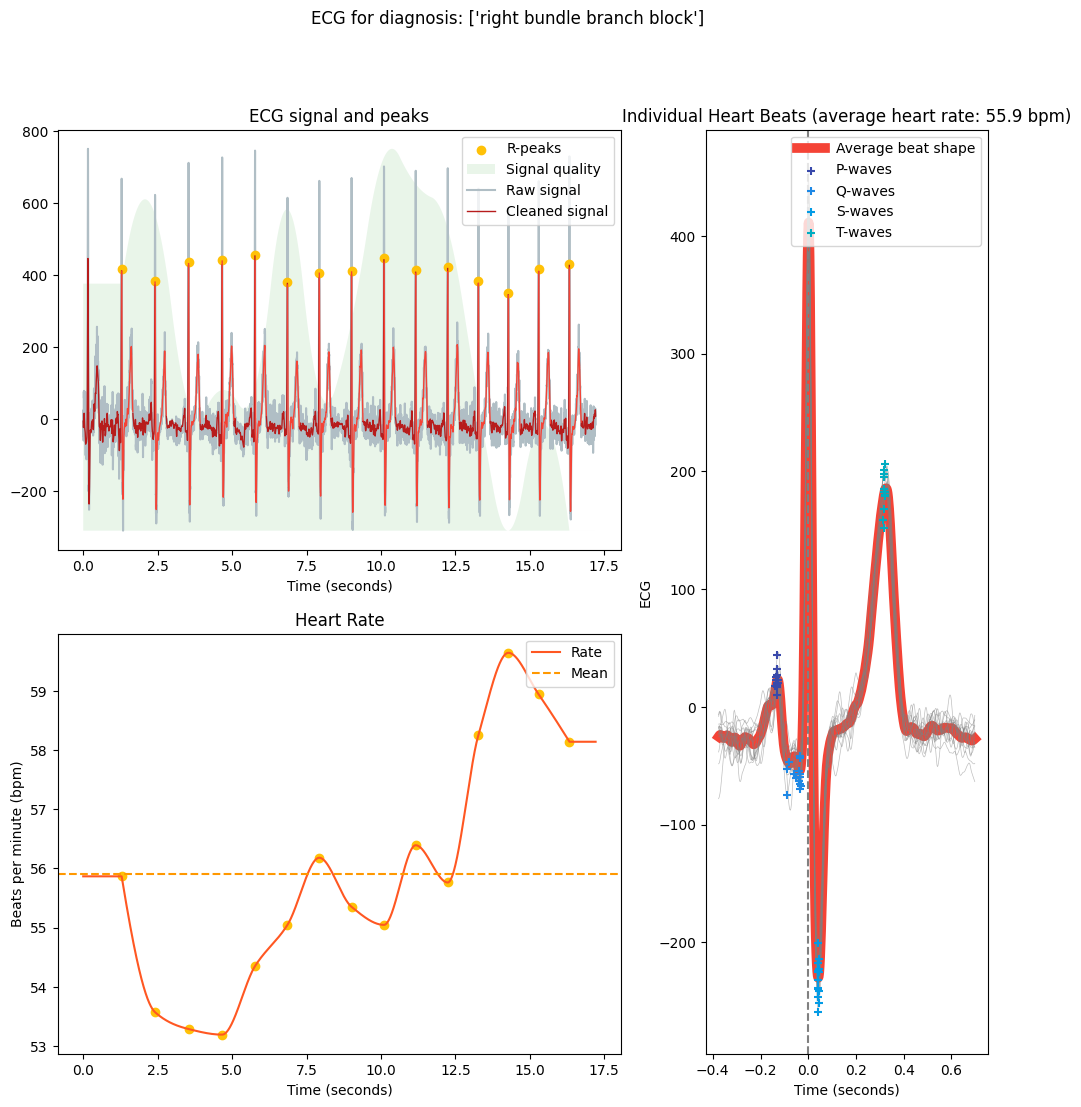

False
False
[39, 52, 38, 64, 40, 60, 39, 36, 37, 40, 47, 43, 64, 39]


In [12]:
#RBBB
data_directory="../data/physionet.org/files/challenge-2021/1.0.3/training/cpsc_2018/g3"

header_files, recording_files = find_challenge_files(data_directory)
num_recordings = len(header_files)
index_RBBB = header_files.index('../data/physionet.org/files/challenge-2021/1.0.3/training/cpsc_2018/g3/A2000.hea')
    
print(f"Finished loading: {num_recordings} files")

header = load_header(header_files[index_RBBB])
print(header)
current_labels= clean_labels(header)
print(current_labels)
current_abbreviations=[labels_to_class[int(label)] for label in current_labels]
print(current_abbreviations)

recording = np.array(load_recording(recording_files[index_RBBB]), dtype=np.float32)
recording_full = get_leads_values(header, recording, leads)

signals_I, info_I = nk.ecg_process(recording[0], sampling_rate=500)

# Visualise the processing
plt.close()
nk.ecg_plot(signals_I, info)
fig = plt.gcf() 
fig.set_size_inches(12, 12, forward=True)
fig.suptitle(f"ECG for diagnosis: {current_abbreviations}")
plt.show()

bpm=np.mean(nk.ecg_rate(signals_I, sampling_rate=500))

print(has_missing_qrs(signals_I, info_I))
print(has_missing_p(signals_I, info_I))
print(get_QRS_duration(signals_I, info_I))


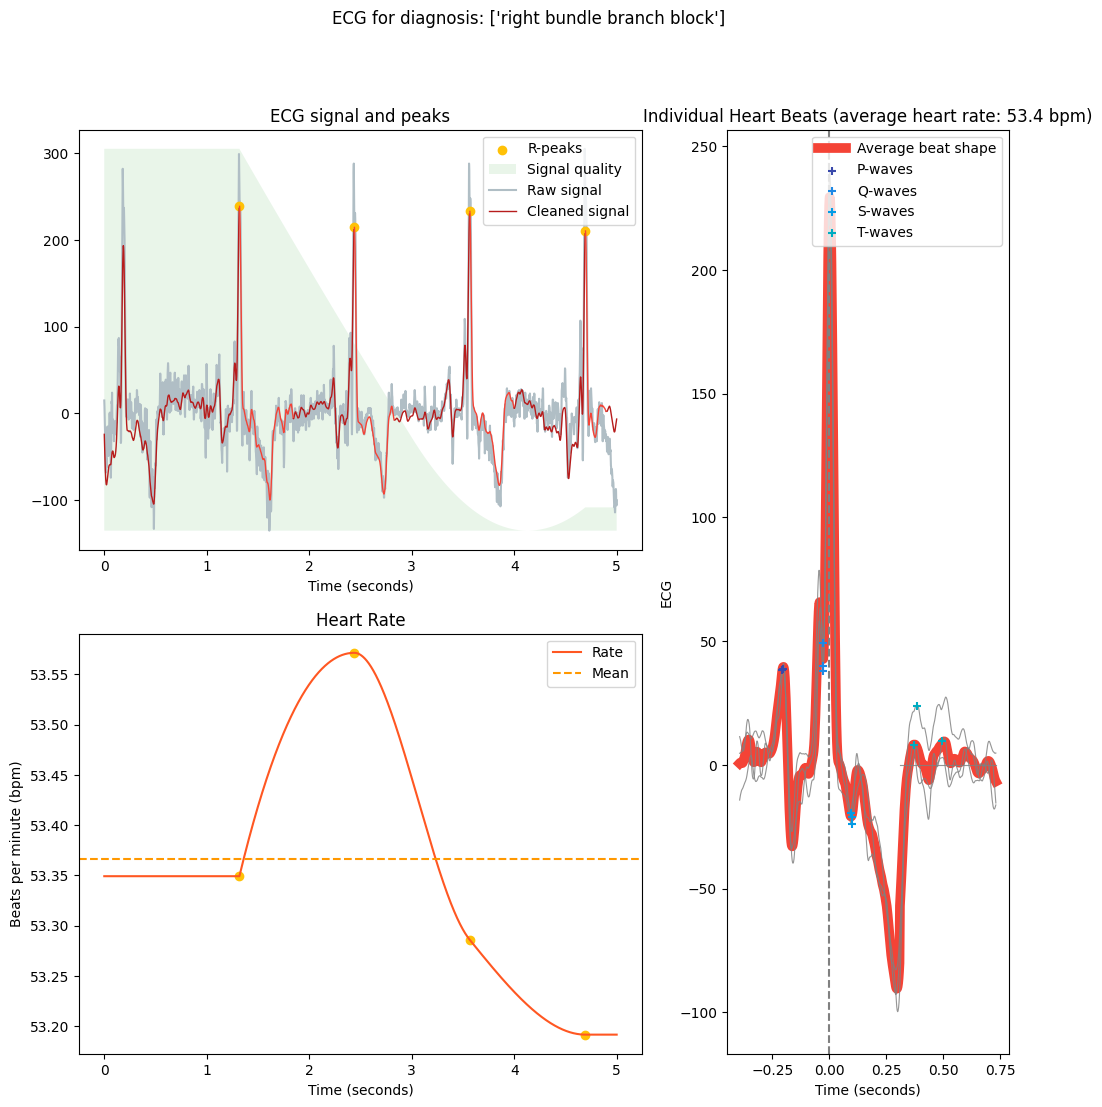

False
False
[63, 62, 60]


In [13]:
signals_V1, info_V1 = nk.ecg_process(recording[6][:2500], sampling_rate=500)

# Visualise the processing
plt.close()
nk.ecg_plot(signals_V1, info_V1)
fig = plt.gcf() 
fig.set_size_inches(12, 12, forward=True)
fig.suptitle(f"ECG for diagnosis: {current_abbreviations}")
plt.show()

bpm=np.mean(nk.ecg_rate(signals_V1, sampling_rate=500))

print(has_missing_qrs(signals_V1, info_V1))
print(has_missing_p(signals_V1, info_V1))
print(get_QRS_duration(signals_V1, info_V1))

Is inverted: False


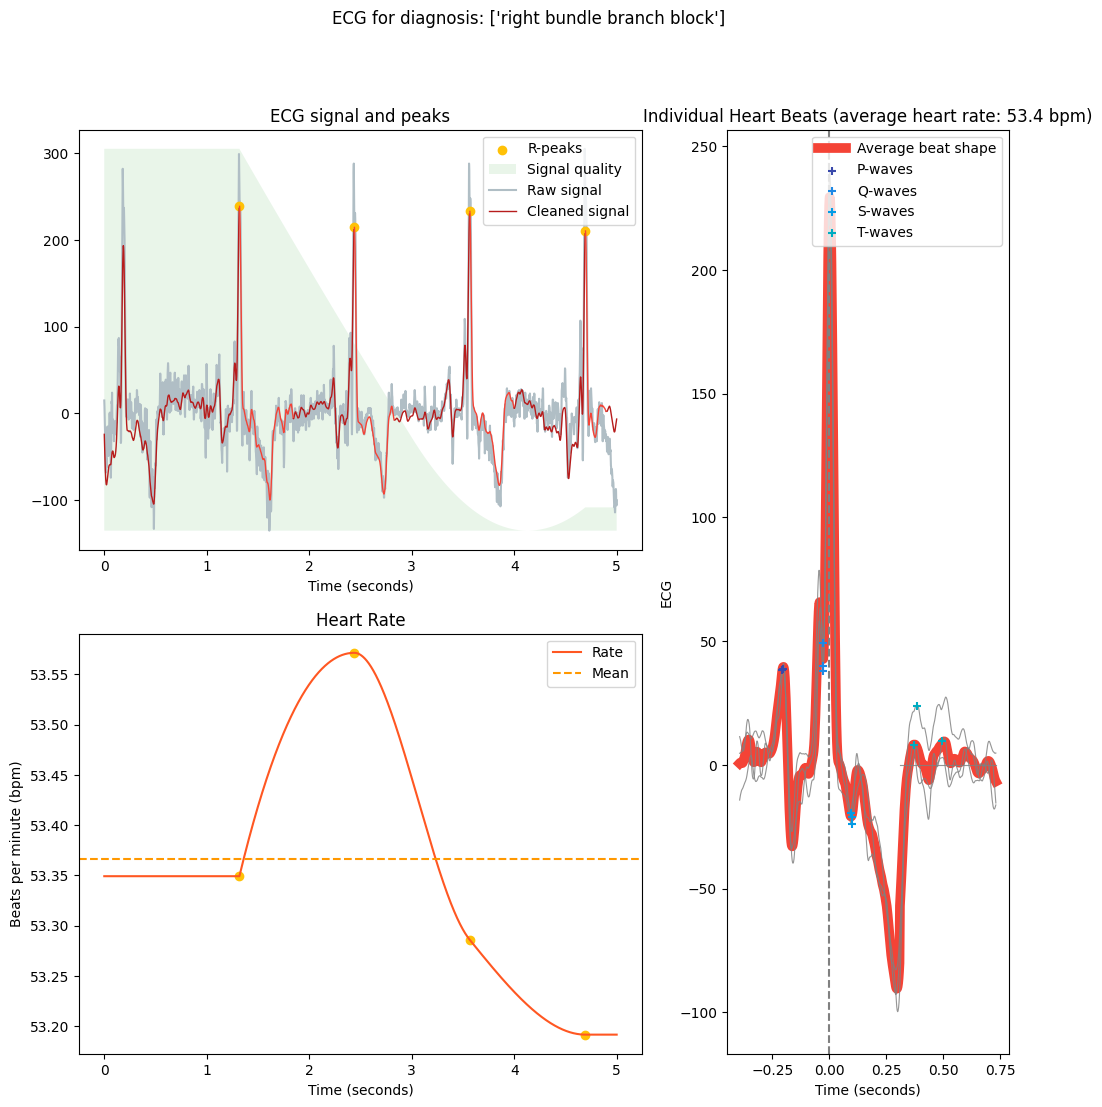

In [14]:
ecg, inverted = nk.ecg_invert(recording[6][:2500], sampling_rate=500)
print(f"Is inverted: {inverted}")

signals_V1, info_V1 = nk.ecg_process(ecg, sampling_rate=500)

# Visualise the processing
plt.close()
nk.ecg_plot(signals_V1, info_V1)
fig = plt.gcf() 
fig.set_size_inches(12, 12, forward=True)
fig.suptitle(f"ECG for diagnosis: {current_abbreviations}")
plt.show()

{'method_peaks': 'neurokit', 'method_fixpeaks': 'None', 'ECG_R_Peaks': array([ 659, 1219, 1782, 2346]), 'ECG_R_Peaks_Uncorrected': array([ 659, 1219, 1782, 2346]), 'ECG_fixpeaks_ectopic': [], 'ECG_fixpeaks_missed': [], 'ECG_fixpeaks_extra': [], 'ECG_fixpeaks_longshort': [], 'ECG_fixpeaks_method': 'kubios', 'ECG_fixpeaks_rr': array([1.12466667, 1.12      , 1.126     , 1.128     ]), 'ECG_fixpeaks_drrs': array([ 0.13262599, -0.55702918,  0.71618037,  0.23872679]), 'ECG_fixpeaks_mrrs': array([-0.14652015, -1.17216117,  0.07326007,  0.29304029]), 'ECG_fixpeaks_s12': array([-0.55702918,  0.13262599,  0.23872679,  0.71618037]), 'ECG_fixpeaks_s22': array([-0.55702918,  0.71618037,  0.23872679, -0.55702918]), 'ECG_fixpeaks_c1': 0.13, 'ECG_fixpeaks_c2': 0.17, 'sampling_rate': 500, 'ECG_P_Peaks': [555, 1116, 1678, 2242], 'ECG_P_Onsets': [533, 1094, 1640, 2224], 'ECG_P_Offsets': [574, 1136, 1698, 2263], 'ECG_Q_Peaks': [644, 1205, 1768, nan], 'ECG_R_Onsets': [638, 1200, 1760, nan], 'ECG_R_Offsets':

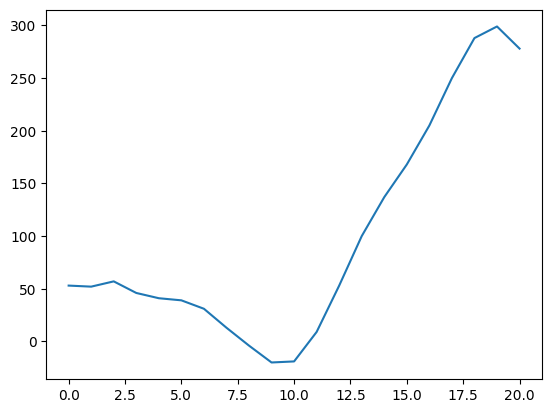

In [15]:
print(info_V1)

y = signals_V1['ECG_Raw'].iloc[638:659].values
x = range(len(y))
print(y)

print(np.diff(((y > 0).astype(int))))
plt.plot(x,y)

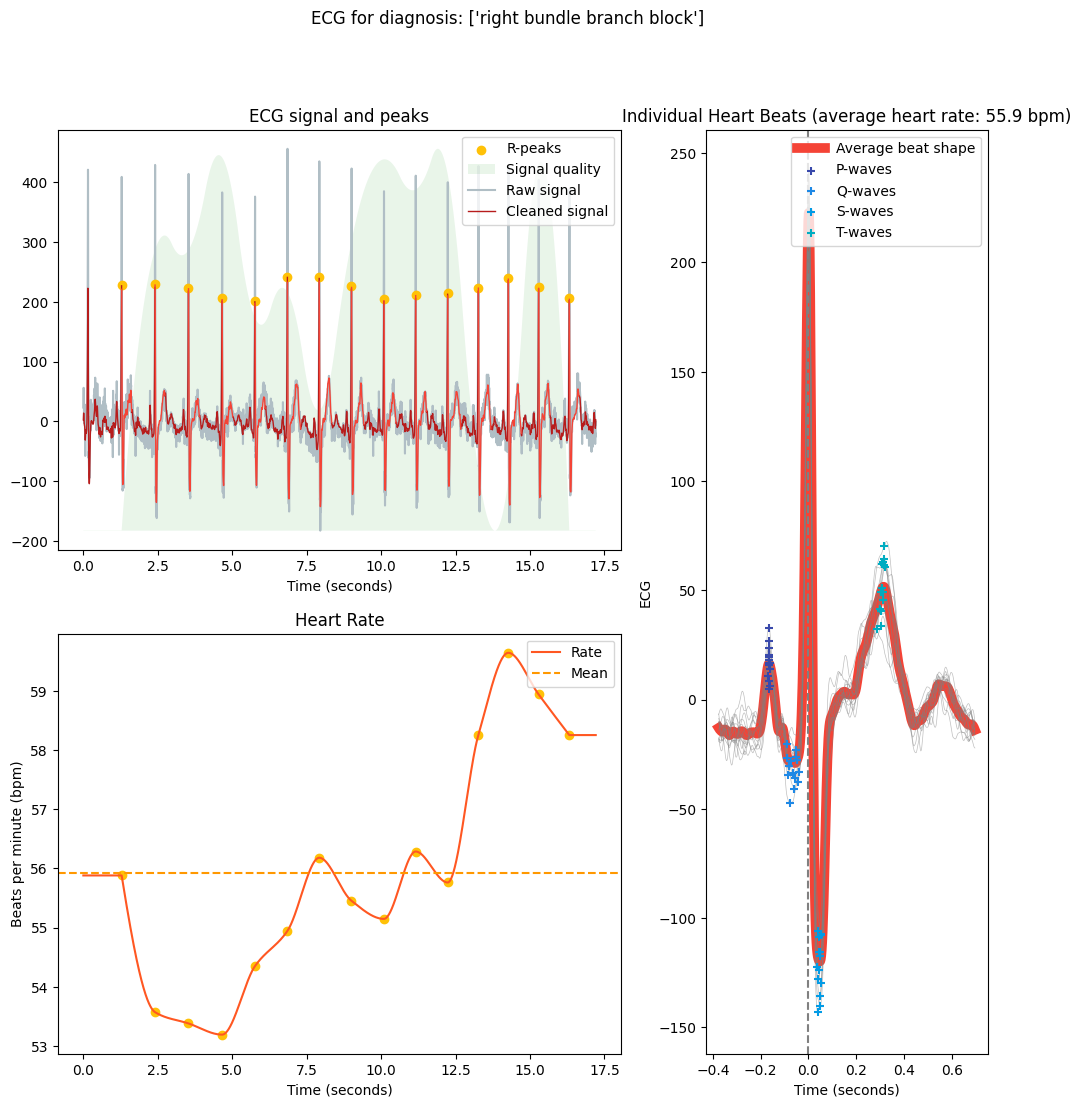

False
False
[65, 68, 51, 56, 50, 69, 59, 45, 50, 58, 54, 44, 45, 62]


In [16]:
signals_V6, info_V6 = nk.ecg_process(recording[11], sampling_rate=500)

# Visualise the processing
plt.close()
nk.ecg_plot(signals_V6, info_V6)
fig = plt.gcf() 
fig.set_size_inches(12, 12, forward=True)
fig.suptitle(f"ECG for diagnosis: {current_abbreviations}")
plt.show()

bpm=np.mean(nk.ecg_rate(signals_V6, sampling_rate=500))

print(has_missing_qrs(signals_V6, info_V6))
print(has_missing_p(signals_V6, info_V6))
print(get_QRS_duration(signals_V6, info_V6))

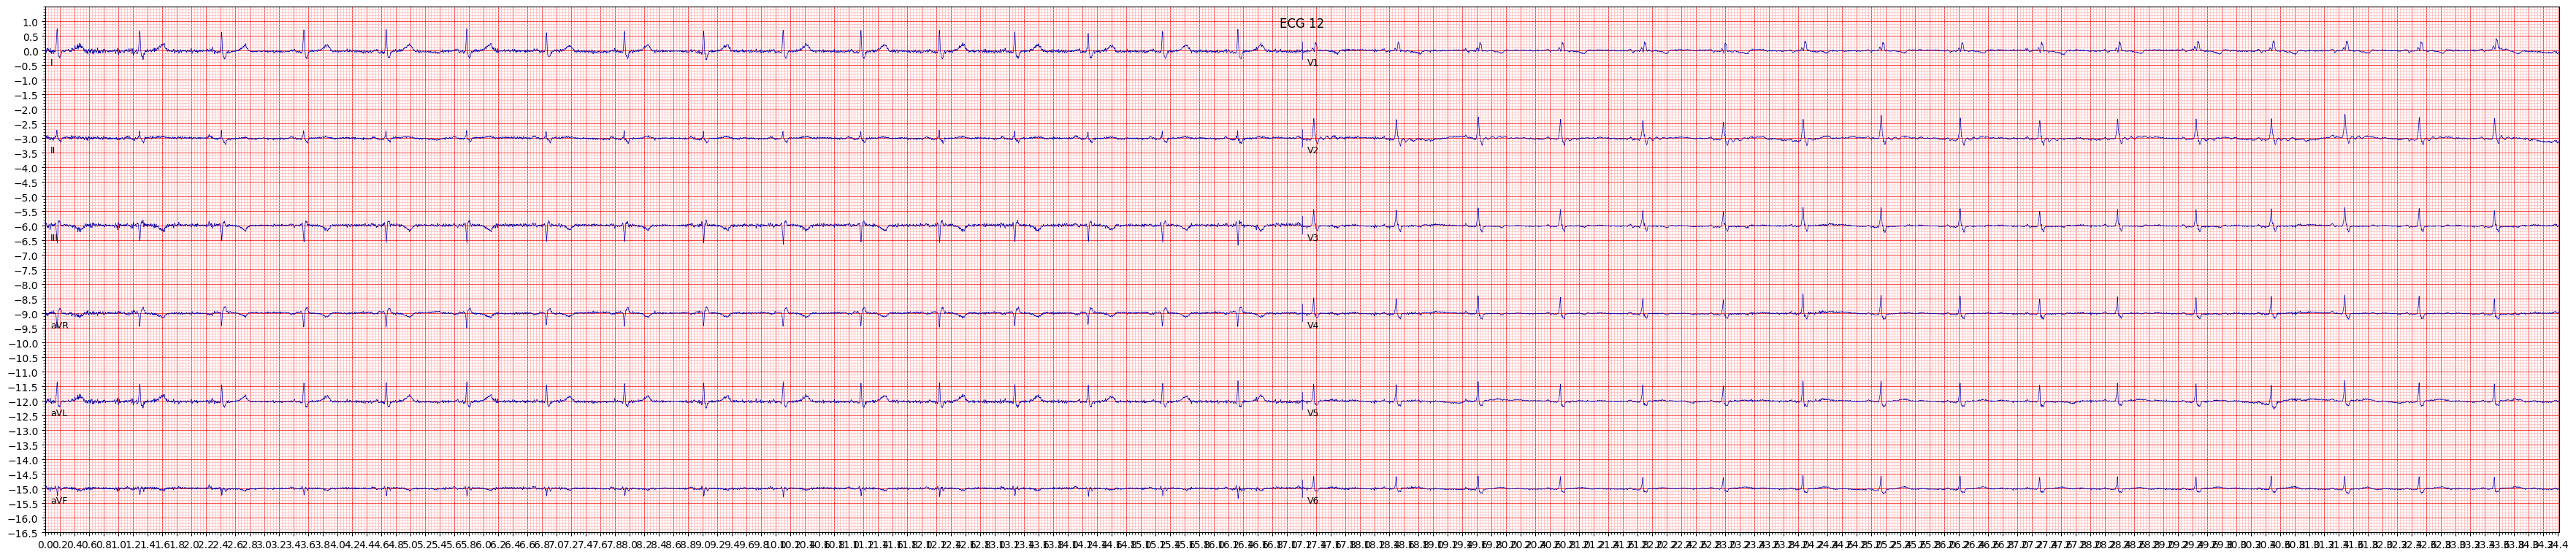

In [17]:
ecg_plot.plot(recording / 1000, sample_rate = 500, title = 'ECG 12')
ecg_plot.show()

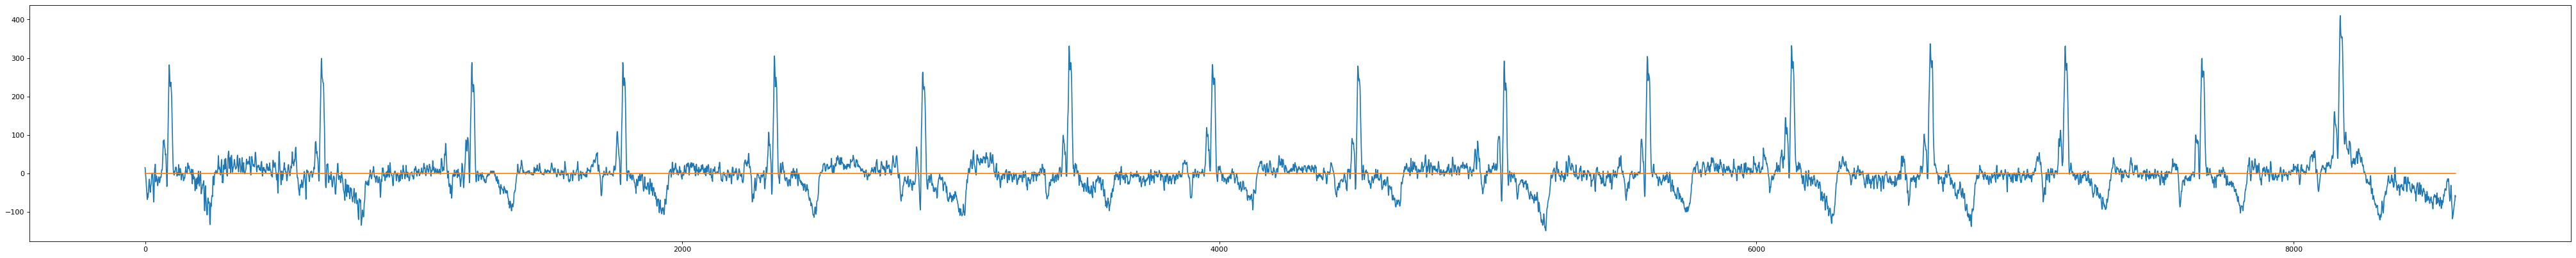

In [18]:
x = range(len(recording[6]))
plt.figure(figsize=(64, 6), dpi=80)
plt.plot(x, recording[6])
plt.plot(x, np.zeros(len(x)))



In [25]:
def has_rsR_complex(recording, threshold=10):
    ecg, inverted = nk.ecg_invert(recording, sampling_rate=500)
    print(f"Is inverted: {inverted}")
    signals, info = nk.ecg_process(ecg, sampling_rate=500)

    #For V1 with rSR there should be no inversion. If V1 is healthy inversion would occurr
    if not inverted:
        num_peaks = len(info['ECG_R_Peaks'])
        result = []
        for i in range(num_peaks):
            r = info['ECG_R_Peaks'][i]
            r_on = info['ECG_R_Onsets'][i]
            r_off = info['ECG_R_Offsets'][i]
  
            if np.isnan([r, r_on, r_off]).any() or r_on-threshold < 0:
                continue
            else:
                if signals.iloc[r_on]['ECG_Raw'] > 0:
                    result.append(any(signals.iloc[r_on:r]['ECG_Raw'] < 0))
                else:
                    #TODO? What if R_onset is not positive?
                    # Lets see how many times we crossed from positive to negative again, if > 0 between ron and r then its rsr
                    pos_to_neg_changes = sum(np.diff((signals.iloc[r_on:r]['ECG_Raw'] > 0).astype(int))<0)
                    result.append(pos_to_neg_changes>0)
      
        return int(any(result))
    else:
        return -1
        

print(has_rsR_complex(recording[6]))
print(has_rsR_complex(recording_good[6]))
    

1
-1


In [33]:
class_files={}
for i in range(len(header_files)):
    header = load_header(header_files[i])
    labels = clean_labels(header)
    #tylko główna diagnoza
    l = labels[0]
    if l in class_files:
        class_files[l].append((header_files[i], recording_files[i]))
        
    else:
        class_files[l]=[(header_files[i], recording_files[i])]

for k, v in class_files.items():
    print(k)
    print(len(v))


426783006
135
164884008
98
164889003
173
429622005
111
59118001
250
164931005
30
270492004
103
284470004
74
164909002
26


In [34]:
has_rsr = []
for header_file, recording_file in class_files['59118001']:
    header = load_header(header_file)
    rec = np.array(load_recording(recording_file), dtype=np.float32)
    has_rsr.append(has_rsR_complex(rec[6]))

print(has_rsr)
    


    

[0, 0, 1, 1, 0, -1, -1, -1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, -1, 0, -1, 1, 1, 1, -1, 0, 1, 0, -1, -1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, -1, 0, 0, -1, 1, -1, 0, 0, -1, 0, 1, 0, 1, 0, 0, 1, 1, 1, -1, 1, 0, 1, 1, -1, 1, 1, 1, 0, 1, 1, 0, 0, -1, 0, 1, -1, 0, 1, 1, 1, 1, 1, 1, 1, 1, -1, 1, 1, 0, -1, 0, 1, 1, 1, 0, 1, 1, 1, 0, -1, 1, -1, 0, 0, 0, 0, 1, 1, 0, 1, -1, 1, 0, 1, -1, -1, -1, -1, 1, 1, -1, 1, -1, 0, 1, -1, 0, 0, 1, 0, -1, 1, 1, -1, 1, 0, 1, 0, -1, -1, -1, 1, 0, -1, 1, 1, 0, 1, 1, -1, -1, 0, 1, 1, -1, 1, 1, 1, 1, 0, 1, 1, 1, -1, 1, 0, 0, 1, 1, 1, -1, 1, 1, -1, 1, 1, 1, 0, -1, 1, 1, 0, 1, 1, 0, 0, -1, 1, 0, 1, 1, 1, -1, 0, -1, 0, 1, -1, 1, 0, 1, 1, 1, 0, -1, 1, 0, 0, 1, -1, 1, -1, 1, 1, 1, 1, 0, 1, 1, -1, 1, -1, 1, 0, 1, 1, 1, 1, 0, 1, 0, -1, -1, 0, 1, -1, -1, -1, 0, 1]


A2338 12 500 5920
A2338.mat 16x1+24 1000.0(0)/mV 16 0 -15 -59 0 I
A2338.mat 16x1+24 1000.0(0)/mV 16 0 -10 -34 0 II
A2338.mat 16x1+24 1000.0(0)/mV 16 0 5 14 0 III
A2338.mat 16x1+24 1000.0(0)/mV 16 0 12 35 0 aVR
A2338.mat 16x1+24 1000.0(0)/mV 16 0 -10 -24 0 aVL
A2338.mat 16x1+24 1000.0(0)/mV 16 0 -2 10 0 aVF
A2338.mat 16x1+24 1000.0(0)/mV 16 0 75 50 0 V1
A2338.mat 16x1+24 1000.0(0)/mV 16 0 48 0 0 V2
A2338.mat 16x1+24 1000.0(0)/mV 16 0 -48 -54 0 V3
A2338.mat 16x1+24 1000.0(0)/mV 16 0 -36 -69 0 V4
A2338.mat 16x1+24 1000.0(0)/mV 16 0 -11 -44 0 V5
A2338.mat 16x1+24 1000.0(0)/mV 16 0 -36 -37 0 V6
# Age: 30
# Sex: Female
# Dx: 59118001
# Rx: Unknown
# Hx: Unknown
# Sx: Unknown



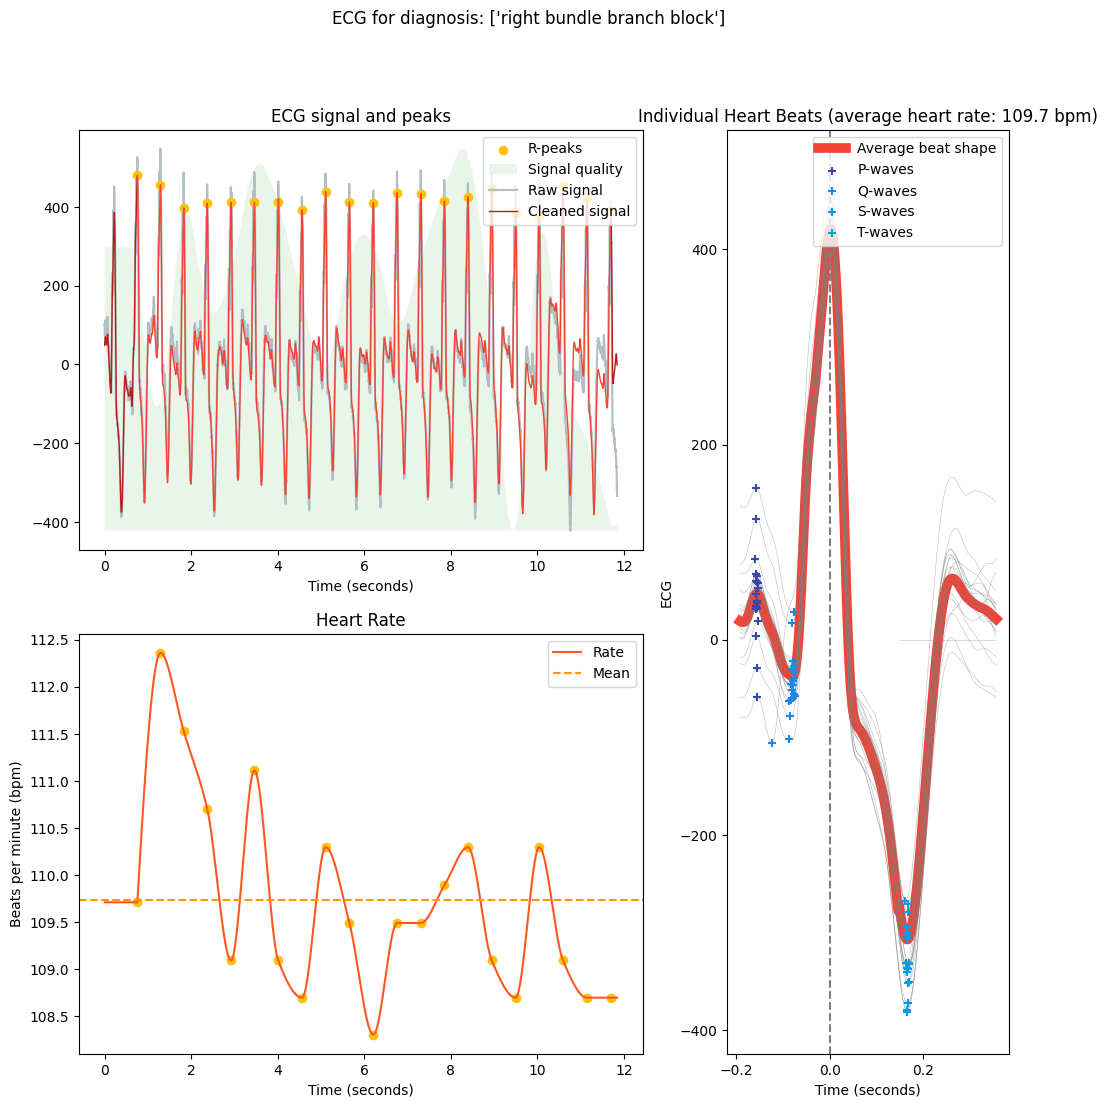

In [41]:
header_file, recording_file = class_files['59118001'][1]
header = load_header(header_file)
print(header)
rec = np.array(load_recording(recording_file), dtype=np.float32)
ecg, inverted = nk.ecg_invert(rec[6], sampling_rate=500)
signals, info = nk.ecg_process(ecg, sampling_rate=500)
nk.ecg_plot(signals, info)
fig = plt.gcf() 
fig.set_size_inches(12, 12, forward=True)
fig.suptitle(f"ECG for diagnosis: {current_abbreviations}")
plt.show()


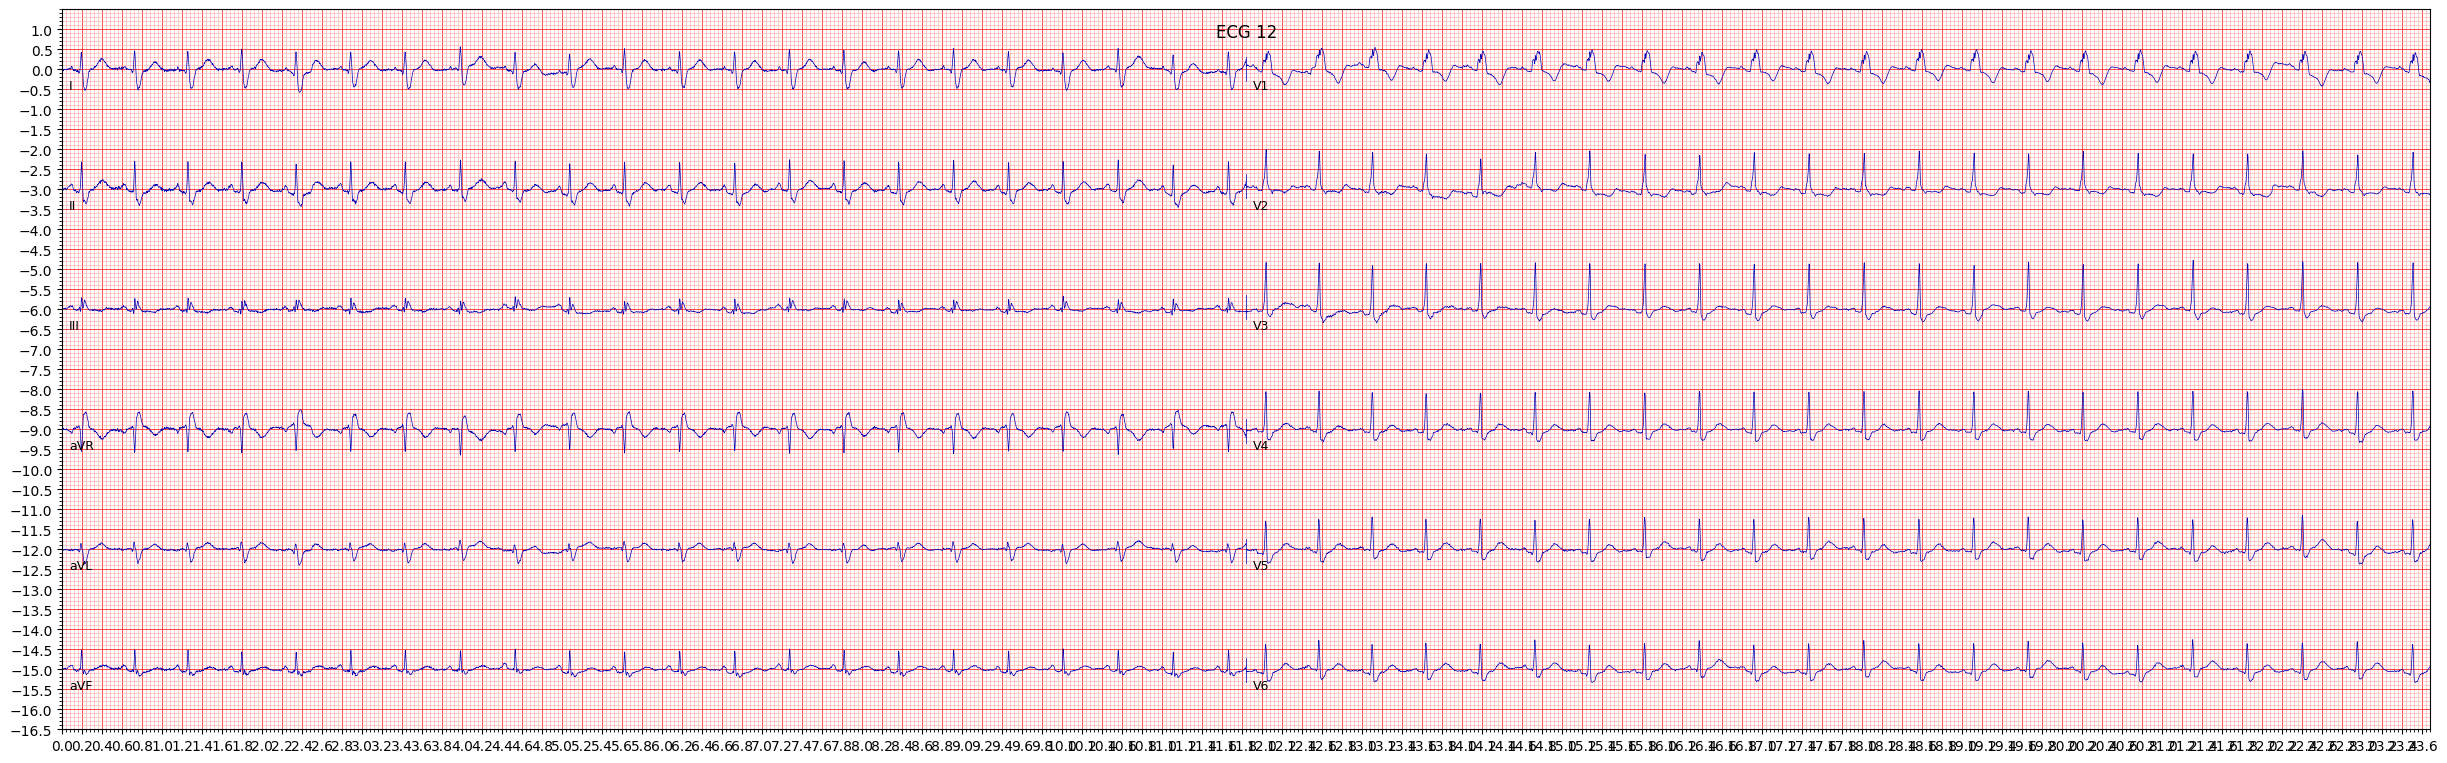

In [42]:
ecg_plot.plot(rec / 1000, sample_rate = 500, title = 'ECG 12')
ecg_plot.show()